# Price Regression

In this notebook, we will try to predict a product's price with both ingredient and non-ingredient features, and assess the relative importance of ingredients in determining price versus other factors such as brand and packaging.

Model pipeline:
<img src="../documents/images/price_regression_flow_chart.png" width="700" />

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
import itertools
import gc

import sys
sys.path.append('../utilities')
from data_utils import *
from ml_utils import *
from stats_utils import *

#### Read and Prepare data

We are going to predict all skin-care, body-care and makeup products. We will drop products with price higher than 300 for this study.

In [2]:
# read cleaned data
skin_care_df = pd.read_csv('../data_cleaning/skin_care_cleaned.csv')
body_care_df = pd.read_csv('../data_cleaning/body_care_cleaned.csv')
makeup_df = pd.read_csv('../data_cleaning/makeup_cleaned.csv')

# merge skin-care, body-care and makeup table
df = pd.concat([skin_care_df,body_care_df,makeup_df], sort=False).reset_index(drop=True)

# drop outlier
df = df.loc[df['price']<300].reset_index(drop=True)

#### Merge image predictions to dataframe

In packaging_to_price.ipynb, we predicted the price using product images. Here we merge the predictions as one feature to our dataset.

In [3]:
cols = ['product_names','brand','predicted_price','fold']
image_df = pd.read_csv('image_prediction.csv', usecols=cols) 
image_df.rename({'predicted_price':'image_price'},axis=1,inplace=True)
df = df.merge(image_df.groupby(['product_names','brand']).first(), on=['product_names','brand'], how='left')
del image_df
gc.collect()

42

#### Add more features
* Count ingredients that are "xxx extract", peptide, "xxx oil" --- these are special categories we found in EDA that may be associated with price.
* Individule ingredient binary count --- the matrix is sparse and has too many columns, we cannot use it directly, so we will use chi2 test to pick a few that are important.
* Similar to the idea of tf-idf, we can turn our individule ingredient count to "if-ipf"(ingredient frequency - inverse product frequency), which penalize common ingredients. Then we use NMF to get 50 compenents as features.
* Note while doing "if-ipf" and NMF, we only fit on training set, and then transform both train and test set.

In [4]:
# count ingredients that that are "xxx extract", peptide, "xxx oil"
df['count_extract'] = df['inactive_ingredient_list'].apply(count_pattern, pattern='extract')
df['count_peptide'] = df['inactive_ingredient_list'].apply(count_pattern, pattern='peptide')
df['count_oil'] = df['inactive_ingredient_list'].apply(count_pattern, pattern='oil')

# count ingredient
ingredient_count_df = get_matching_ingredient_count(df)

# select important individule ingredient using chi-square test
interesting_ingredients = []
for col in ingredient_count_df.columns.values:
    count_ingredient = ingredient_count_df[col].sum()
    if count_ingredient > 100 and count_ingredient < 500:
       interesting_ingredients.append(col) 
    
price_band, bins = pd.qcut(df['price'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=False, retbins=True)
ingredient_count_df['price_band'] = price_band.reset_index(drop=True)

results = chi2_contingency(ingredient_count_df, interesting_ingredients, 'price_band').sort_values('p-value')
top_ingredients = results.index.values[:50]
print("individule ingredient picked:\n", top_ingredients)

# create "if-ipf"(ingredient frequency - inverse product frequency) and use 50 NMF compenents as features
ingredient_count_df.drop(['price_band'], axis=1, inplace=True)
pipeline = make_pipeline(TfidfTransformer(),NMF(n_components=50))
pipeline.fit(ingredient_count_df.loc[df['fold']!=-1])
if_ipf_nmf = pipeline.transform(ingredient_count_df)
if_ipf_nmf_df = pd.DataFrame(if_ipf_nmf)
if_ipf_nmf_df = if_ipf_nmf_df.add_prefix('if_pif_nmf_') 

# merge the new features to dataframe
df = pd.concat([df, if_ipf_nmf_df, ingredient_count_df[top_ingredients]], axis=1)
df.head()

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/contingency.py:242: RuntimeWarning: invalid value encountered in less
  if np.any(observed < 0):


individule ingredient picked:
 ['acetyl hexapeptide-8' 'algae extract' 'caffeine'
 'palmitoyl oligopeptide' 'hydrogenated lecithin' 'alpha isomethyl ionone'
 'trehalose' 'linoleic acid' 'phospholipid' 'PEG-8' 'polysilicone-11'
 'butylparaben' 'palmitoyl tetrapeptide-7' 'retinol'
 'tetrahexyldecyl ascorbate' 'urea' 'ascorbyl palmitate' 'polysaccharide'
 'bromelain' 'hydrolyzed wheat protein' 'Palmitoyl Tripeptide-38'
 'hydrolyzed algae extract' 'Calluna vulgaris flower extract'
 'butylphenyl methylpropional' 'lysine' 'acetyl glucosamine'
 'sodium metabisulfite' 'acetic acid' 'glycolic acid' 'polysorbate 80'
 'Scutellaria baicalensis extract' 'isobutylparaben'
 'hydrolyzed soy protein' 'arginine' 'polymethylsilsesquioxane'
 'DMDM hydantoin' 'cholesterol' 'glyceryl polymethacrylate'
 'sorbitan stearate' 'petrolatum' 'dipotassium glycyrrhizate'
 'propylene glycol dicaprylate' 'cyclohexasiloxane' 'sorbitol'
 'saccharide isomerate' 'phenyl trimethicone' 'grape seed extract'
 'sucrose' 'sodiu

,product_names,product_category,brand,ingredient,size,price,size_num,size_unit,avg_price,active_ingredient,...,dipotassium glycyrrhizate,propylene glycol dicaprylate,cyclohexasiloxane,sorbitol,saccharide isomerate,phenyl trimethicone,grape seed extract,sucrose,sodium gluconate,retinyl retinoate
0,Clear Complexion Spot Treatment,Acne & Blemish Treatment,Merle Norman,"Active: Salicylic Acid (2%), Other: Alcohol D...",0.50 fl. oz.,20.00,15.0,ml,1.333333,"Salicylic Acid (2%),",...,0,0,0,0,0,0,0,0,0,0
1,Acne Solutions Emergency Gel Lotion,Acne & Blemish Treatment,Clinique,"Active: Benzoyl Peroxide (5%), Other: Water P...",0.50 fl. oz.,17.00,15.0,ml,1.133333,"Benzoyl Peroxide (5%),",...,0,0,0,0,0,0,0,1,0,0
2,RESIST Daily Pore-Refining Solution 2% BHA,Acne & Blemish Treatment,Paula's Choice Skincare,"Water (Aqua), Dipropylene Glycol, Salicylic ...",3.00 fl. oz.,33.00,89.0,ml,0.370787,NaN,...,1,0,0,0,0,0,0,0,0,0
3,Max Complexion Correction Pads,Acne & Blemish Treatment,Peter Thomas Roth,"Active: Salicylic Acid (2%), Other: Alcohol D...",60.00,40.00,60.0,NaN,0.666667,"Salicylic Acid (2%),",...,0,0,0,0,0,0,0,0,0,0
4,Naturals Acne Spot Treatment,Acne & Blemish Treatment,Neutrogena,Active Ingredient: Salicylic Acid 1%. Inactive...,0.75 fl. oz.,8.49,22.0,ml,0.385909,Salicylic Acid 1%.,...,0,0,0,0,0,0,0,0,0,0


#### Define feature set

In [5]:
target = 'price'
meanenc_feats = ['product_category', 'brand', 'size_unit']
gen_features = ['product_category_mean_encode', 'brand_mean_encode', 'size_num', 'size_unit_mean_encode','image_price']
ingredient_features = ['n_inactive_ingredient','n_active_ingredient','active_mean_rating', 'inactive_mean_rating', 'inactive_mean_rating_w1','inactive_mean_rating_w2']
ingredient_features += [f_ for f_ in df.columns.values if f_.find('count')>=0]
ingredient_features += [f_ for f_ in df.columns.values if f_.find('_nmf_')>=0]
ingredient_features += list(top_ingredients)

#### Custom KFolds
We will use the same customized folds as we did in image-to-price prediction, so we define the custom_folds class that allows us to use it in place of KFolds. The class is initialized with predefined folds information (the series "fold") and returns indices when calling split().

In [6]:
class custom_folds:
    
    def __init__(self, folds):
        self.n_folds = folds.nunique()
        self.folds = [list(np.where(folds.values==i)[0]) for i in range(self.n_folds)]
        self.n_row = folds.shape[0]
        
    def split(self, dummy):
        assert(dummy.shape[0] == self.n_row)
        return ((self.train_idx(i), self.val_idx(i)) for i in range(self.n_folds))
    
    def train_idx(self, i):
        return self.folds[i]
        
    def val_idx(self, i):
        idx = []
        for n in range(self.n_folds):
            if n!=i:
                idx += self.folds[n]
        
        return list(set(idx))
    
train, test = df.loc[df['fold']!=-1], df.loc[df['fold']==-1]
my_folds = custom_folds(train['fold'])

#### target encoding categorical features

The brand and product category are high-cardinal, target encoding would be the best to deal with them.

In [7]:
pd.options.mode.chained_assignment = None
for col in meanenc_feats:
    train[col+'_mean_encode'] = 0.
    test[col+'_mean_encode'] = 0.
    SMOOTHING = test[~test[col].isin(train[col])].shape[0]/test.shape[0]
    _, test[col+'_mean_encode'] = target_encode(train[col], 
                                      test[col], 
                                      target=train[target], 
                                      min_samples_leaf=10,
                                      smoothing=SMOOTHING,
                                      noise_level=0.02)
    for f, (vis_index, blind_index) in enumerate(my_folds.split(train)):
        _, train[col+'_mean_encode'].iloc[blind_index] = target_encode(train[col].iloc[vis_index], 
                                                            train[col].iloc[blind_index], 
                                                            target=train[target].iloc[vis_index], 
                                                            min_samples_leaf=10,
                                                            smoothing=SMOOTHING,
                                                            noise_level=0.02)     
        


../utilities/ml_utils.py:153: RuntimeWarning: overflow encountered in exp
  smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))


#### First let's build a baseline model with non-ingredient features --- just using brand, category, size and packaging (image predictions) features.

In [8]:
features = gen_features
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

model = LGBMRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, lambda_l2=0.1, random_state=777)
y_train_pred_n = oof_preds(X_train.values, y_train.values, model, folds=my_folds, return_prob=False)

model.fit(X_train, y_train)
y_test_pred_n = model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_n))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_n))

mae_train = mean_absolute_error(y_train, y_train_pred_n)
mae_test = mean_absolute_error(y_test, y_test_pred_n)

ev_train = explained_variance_score(y_train, y_train_pred_n)
ev_test = explained_variance_score(y_test, y_test_pred_n)

print("number of features:",len(features))
print("rmse: (train cv) %.3f, (test) %.3f"%(rmse_train, rmse_test))
print("mae: (train cv) %.3f, (test) %.3f"%(mae_train, mae_test))
print("explained variance: (train cv) %.3f, (test) %.3f"%(ev_train, ev_test))

number of features: 5
rmse: (train cv) 28.495, (test) 19.525
mae: (train cv) 16.648, (test) 11.358
explained variance: (train cv) 0.283, (test) 0.611


#### Use ingredient features to train the model

In [9]:
features = ingredient_features
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

model = LGBMRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, lambda_l2=0.1, random_state=777)
y_train_pred_i = oof_preds(X_train.values, y_train.values, model, folds=my_folds, return_prob=False)

model.fit(X_train, y_train)
y_test_pred_i = model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_i))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_i))

mae_train = mean_absolute_error(y_train, y_train_pred_i)
mae_test = mean_absolute_error(y_test, y_test_pred_i)

ev_train = explained_variance_score(y_train, y_train_pred_i)
ev_test = explained_variance_score(y_test, y_test_pred_i)

print("number of features:",len(features))
print("rmse: (train cv) %.3f, (test) %.3f"%(rmse_train, rmse_test))
print("mae: (train cv) %.3f, (test) %.3f"%(mae_train, mae_test))
print("explained variance: (train cv) %.3f, (test) %.3f"%(ev_train, ev_test))

number of features: 171
rmse: (train cv) 28.916, (test) 24.055
mae: (train cv) 17.936, (test) 15.787
explained variance: (train cv) 0.262, (test) 0.408


All ingredient features together achieve slightly lower accuracy than using non-ingredient features.

#### Now use all features, and see how much can they improve our model

In [10]:
features = gen_features + ingredient_features
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

model = LGBMRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, lambda_l2=0.1, random_state=777)
y_train_pred = oof_preds(X_train.values, y_train.values, model, folds=my_folds, return_prob=False)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

ev_train = explained_variance_score(y_train, y_train_pred)
ev_test = explained_variance_score(y_test, y_test_pred)

print("number of features:",len(features))
print("rmse: (train cv) %.3f, (test) %.3f"%(rmse_train, rmse_test))
print("mae: (train cv) %.3f, (test) %.3f"%(mae_train, mae_test))
print("explained variance: (train cv) %.3f, (test) %.3f"%(ev_train, ev_test))

number of features: 176
rmse: (train cv) 27.014, (test) 17.855
mae: (train cv) 15.324, (test) 10.580
explained variance: (train cv) 0.360, (test) 0.676


With all features together, we are able to improve our model further.

#### scatter plot for predicted vs. true price

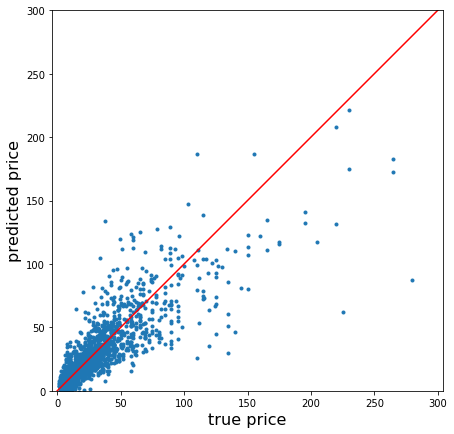

In [11]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_test_pred, marker='.')
plt.plot([0,300],[0,300],color='r')
plt.axis('equal')
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel('true price',fontsize=16)
plt.ylabel('predicted price',fontsize=16)
plt.show()

For very expensive products, our model tend to underestimate the price.

#### Plot feature importance

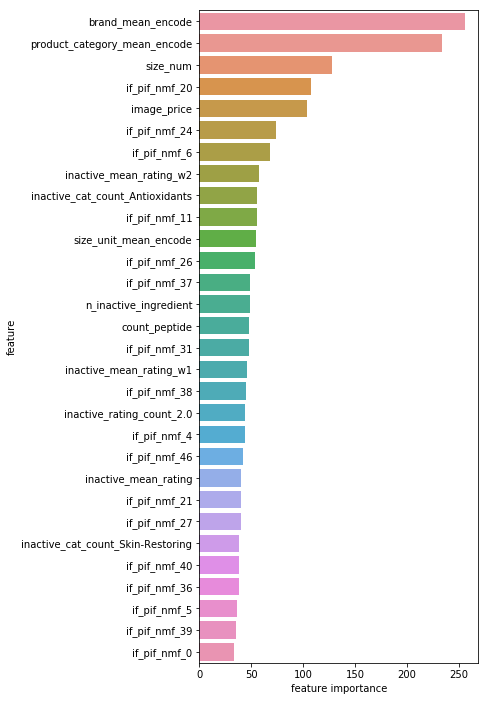

In [12]:
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = features
feature_importance_df['feature importance'] = model.feature_importances_
feature_importance_df = feature_importance_df.sort_values('feature importance', ascending=False)
plt.figure(figsize=(5,12))
sns.barplot(x='feature importance', y='feature', data=feature_importance_df.iloc[:30])
plt.show()

The most important features are product category and Brand. For ingredient-related features, the NMF features are pretty good.

#### Look at some highly overestimated or underestimated examples

In [13]:
under_estimated_samples = np.random.choice(np.where(y_test-y_test_pred>20)[0], size=3)
for i in under_estimated_samples:
    product = test.iloc[i]
    print_product(product)
    print("predicted price")
    print("without ingredient features: %.1f" %y_test_pred_n[i])
    print("with only ingredient features: %.1f" %y_test_pred_i[i])
    print("final (all features): %.1f\n" %y_test_pred[i])

product_name: Retinol Plus Mask
brand: Jan Marini Skin Research, Inc.
category: Face Mask
size: 1.20 fl. oz.
price: 90.0
ingredient: Water/Aqua/Eau,  Kaolin,  Caprylic/Capric Triglyceride,  Glyceryl Stearate,  Glycerin,  Polysorbate 60,  Salicylic Acid,  Stearic Acid,  Polysorbate 20,  Retinol,  Bisabolol,  Oligopeptide-24,  Aloe Barbadensis (Aloe Vera) Leaf Juice,  Carthamus Tinctorius (Safflower) Seed Oil,  Sodium Hyaluronate,  Ceramide 2,  Butyrospermum Parkii (Shea) Butter,  Camellia Oleifera (Green Tea) Leaf Extract,  Aspalathus Linearis Leaf Extract,  Camellia Sinensis Leaf Extract,  Tocopherol,  Tocopheryl Acetate,  Linoleic Acid,  Linolenic Acid,  Stearyl Alcohol,  Hydroxyethyl Acrylate/Sodium Acryloyldimethyl Taurate Copolymer,  Squalane,  Caprylyl Glycol,  Magnesium Aluminum Silicate,  Carrageenan,  Xanthan Gum,  Ethylhexylglycerin,  Hexylene Glycol,  PEG-40 Hydrogenated Castor Oil,  Sodium Hydroxide,  Citric Acid,  Propylene Glycol,  Disodium EDTA,  Phenoxyethanol
predicted 

In [14]:
over_estimated_samples = np.random.choice(np.where(y_test_pred-y_test>20)[0], size=3)
for i in over_estimated_samples:
    product = test.iloc[i]
    print_product(product)
    print("predicted price")
    print("without ingredient features: %.1f" %y_test_pred_n[i])
    print("with only ingredient features: %.1f" %y_test_pred_i[i])
    print("final (all features): %.1f\n" %y_test_pred[i])

product_name: Anti-Aging Foundation SPF 15
brand: La Prairie
category: Foundation
size: nan
price: 110.0
ingredient: Active: Octinoxate (7.5%) Other: Water,  Cyclopentasiloxane,  Ethylhexyl Methoxycinnamate,  Cyclohexasiloxane,  Glycerin,  Isododecane,  Butylene Glycol,  SD Alcohol 40 (Alcohol Denat.),  Lauryl PEG-9 Polydimethylsiloxyethyl Dimethicone,  Polyglyceryl-4 Isostearate,  Cetyl PEG/PPG-10/1 Dimethicone,  Hexyl Laurate,  Disteardimonium Hectorite,  Nylon-12,  Glycoproteins,  Panax Ginseng Root Extract,  Equisetum Arvense (Horsetail) Extract,  Glycine Soja (Soybean) Oil Unsaponifiables,  Ilomastat,  Ursolic Acid,  Hydrogenated Lecithin,  Retinyl Palmitate,  Hydrolyzed Soy Protein,  Ascorbyl Palmitate,  Plankton Extract,  Camellia Sinensis Leaf Extract,  Carnosine,  Sodium Hyaluronate,  Olea Europaea (Olive) Oil Unsaponifiables,  Dimethicone/PEG-10/15 Crosspolymer,  Triticum Vulgare (Wheat) Germ Oil Unsaponifiables,  Algin,  Hydrolyzed Malt Extract,  Polymethyl Methacrylate,  Ph